In [1]:
using LinearAlgebra
using SparseArrays
using Statistics
import Laplacians as Lap
include("Laplacians.jl/src/Laplacians.jl")
import .Laplacians as LapM
import Random
using Plots
using BenchmarkTools
using CUDA
using Graphs
using SNAPDatasets
using GraphIO
using PProf

Using `web-google` as the source dataset. Preprocess the dataset so the adjency matrix represents its largest connected componenet.

In [2]:
# g = loadgraph("graph/web-Google.txt", "graph_key", EdgeListFormat())
g = loadgraph("graph/soc-LiveJournal1.txt", "graph_key", EdgeListFormat())
g = SimpleGraph(g)
g = induced_subgraph(g, connected_components(g)[1])[1]
G = Float64.(sparse(SimpleGraph(g)))
for i in 1:size(G, 1)
    G[i, i] = 0
end
dropzeros!(G)
G

4843953×4843953 SparseMatrixCSC{Float64, Int64} with 85691368 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡆⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣇⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣇⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠿⠿⠿
⠀⠉⠙⠛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠙⠛⠛⠛⠛⠛⠿⠿⠿⠿⠿⠿⠿⠿⢿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀

In [3]:
# calculate its laplacian and ldli
lapG = Lap.lap(G)
ldliG = Lap.approxChol(Lap.LLmatp(G))

Laplacians.LDLinv{Int64, Float64}([4843953, 4305422, 4843924, 4304879, 4842735, 4843952, 4843951, 4843950, 4843949, 4843948  …  38094, 39507, 88625, 18308, 18309, 9744, 88, 36193, 9724, 8485], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  137128767, 137128776, 137128784, 137128791, 137128797, 137128802, 137128806, 137128809, 137128811, 137128812], [4305422, 4843924, 4304879, 4842735, 4282433, 4305396, 4305396, 4305352, 4305336, 4305313  …  9724, 4305461, 8485, 36193, 4305461, 8485, 9724, 4305461, 8485, 4305461], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1985538892014385, 0.28178718383025936, 0.4526051289268562, 1.0, 0.19949052688974087, 0.48540663263338935, 1.0, 0.3171968037546847, 1.0, 1.0], [0.03184600106201637, 0.020945596285240675, 0.027862247338897007, 0.029912844815542634, 0.06603276498586526, 0.17992495152982085, 0.013361017725566854, 0.03799512888740531, 0.13315250282596325, 0.09069106213928149  …  1.0, 0.11111111111111116, 0.12500000000000022, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [4]:
# use a random vector as the input for calculation
vec = randn(size(G, 1))

4843953-element Vector{Float64}:
 -0.09533567907685503
  0.1195612865300453
  1.1493735522157873
  1.5639055017809382
  1.566265119514536
 -0.2846091894128109
 -0.18724387857368874
 -0.7850321313058799
  0.39147352202074
 -1.1659561557360798
 -0.35698597792872344
 -2.7674692563592367
  2.4807403305707605
  ⋮
 -0.14657380642433562
  0.04567420257886029
  2.8256277107923355
  0.7538410225355587
  1.6898891644371956
  0.0886536242616611
  1.3528344800683727
 -0.1438129283991453
  0.7641483342088082
 -0.6928292263128734
 -0.4422055756397205
 -0.6898674351034176

# Baseline

Baseline code and its performance. For a precise measurement, adapt an inplace version

In [5]:
# this version make change to b inplace. The caller should first make a copy of b.
function LDLsolver!(ldli::Lap.LDLinv, b::Vector)
    # y = copy(b)

    @time Lap.forward!(ldli, b)

    @time @inbounds for i in 1:(length(ldli.d))
        if ldli.d[i] != 0
            b[i] /= ldli.d[i]
        end
    end
    
    @time Lap.backward!(ldli, b)

    @time begin
        mu = mean(b)
        @inbounds for i in eachindex(b)
            b[i] = b[i] - mu
        end
    end
    
end

originalApplyLDLi!(ldli, vec) =  LDLsolver!(ldli, vec)

originalApplyLDLi! (generic function with 1 method)

In [57]:
vecOrig = deepcopy(vec)
@benchmark originalApplyLDLi!(ldliG, vecOrig)

  0.839454 seconds
  0.016716 seconds
  0.651604 seconds
  0.003871 seconds
  0.512815 seconds
  0.012960 seconds
  0.585381 seconds
  0.003878 seconds
  0.569178 seconds
  0.007384 seconds
  0.673561 seconds
  0.004276 seconds
  0.649727 seconds
  0.007407 seconds
  0.671803 seconds
  0.004301 seconds
  0.523020 seconds
  0.007370 seconds
  0.589580 seconds
  0.003849 seconds
  0.494717 seconds
  0.013328 seconds
  0.589417 seconds
  0.003869 seconds
  0.494775 seconds
  0.007386 seconds
  0.593684 seconds
  0.003845 seconds
  0.491808 seconds
  0.007376 seconds
  0.582741 seconds
  0.003862 seconds
  0.495076 seconds
  0.007371 seconds
  0.583794 seconds
  0.003839 seconds
  0.494148 seconds
  0.007375 seconds
  0.586530 seconds
  0.004172 seconds
  0.504528 seconds
  0.007352 seconds
  0.638605 seconds
  0.004283 seconds
  0.579628 seconds
  0.007376 seconds
  0.586820 seconds
  0.003852 seconds
  0.558617 seconds
  0.007388 seconds
  0.626550 seconds
  0.004298 seconds


BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.091 s …   1.198 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.156 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.143 s ± 49.022 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██                                █           █         █  
  ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  1.09 s         Histogram: frequency by time         1.2 s <

 Memory estimate: 22.39 KiB, allocs estimate: 320.

In [7]:
vecOrig = deepcopy(vec)
@time originalApplyLDLi!(ldliG, vecOrig)
vecOrig

  0.495104 seconds
  0.007370 seconds
  0.581757 seconds
  0.004251 seconds
  1.089156 seconds (222 allocations: 13.727 KiB)


4843953-element Vector{Float64}:
 -0.020684048604380223
 -0.00232535206259854
  0.012860970610290678
  0.03059643286951541
  0.0343416872360649
  0.004806452592674759
 -0.021594052356704196
  0.05052002753245688
 -0.017500413986908825
  0.012257045977094094
  0.00399400391825111
 -0.024597414111667604
  0.004397455476009782
  ⋮
 -8.730146670680824
  6.295993902170721
  9.075947410384288
  6.360119263255456
  6.487929601479209
  0.04222762176732431
 -1.0550961449362148
 -0.09251953137209057
  8.335350177186228
 -4.794459629798894
 -4.5438359791260154
 -3.092592691057689

# Analyze and test Reordering

At this point, `float64` is still used to perform computation, so that the result can match.

In [47]:
# the analyzer
function analyzeForward(ldli)
    levelSets = Vector{Vector{Int64}}(undef, 0)
    numLevels = 0

    count = zeros(Int64, size(ldli.col, 1) + 1) # each entry for a row entry
    levels = ones(Int64, size(ldli.col, 1) + 1) # each entry for a row entry, all start with level 1
    
    backptr = similar(ldli.rowval) # generate reverse pointer pointing back to 

    for it in 1:length(ldli.col)
        i = ldli.col[it]
    
        j0 = ldli.colptr[it]
        j1 = ldli.colptr[it + 1] - 1
        
        for up in j0:j1
            uprow = ldli.rowval[up]
            if uprow != i # self edge should not count
                count[uprow] = count[uprow] + 1 # following iteration that depends need another update
                levels[uprow] = max(levels[uprow], levels[i] + 1)
            end
            backptr[up] = it # pointing back to the iteration index
        end
        
        if levels[i] > numLevels
            numLevels = numLevels + 1
            push!(levelSets, [it]) # push the iteration number
        else
            push!(levelSets[levels[i]], it) # push the iteration number
        end
    end
    
    return levelSets, numLevels, count, backptr
end

function flattenLevelSets(levelSets, N)
    offsets = Int64[]
    curTotal = 0
    flatLevelSets = Int64[]
    cut = 0
    for level in levelSets
        push!(offsets, curTotal)
        flatLevelSets = vcat(flatLevelSets, level)
        curTotal += length(level)
        if cut == 0 && length(level) < 10000 && (curTotal > N * 0.975)
            cut = length(offsets)
        end
    end
    
    push!(offsets, curTotal)
    return flatLevelSets, offsets, cut
end

# based on the levelSets information, produce another ldli that is reordered (to improve cache performance)
# exclude the allocation time
function reorderLDLi(ldli, levelSets, res, parts)
    curOp = 1 # current op to update
    curit = 1 # current iteration to update
    curptr = 2 # current ptr to update
    
    parts[1] = 0
    curpar = 2
    cumpar = 0
    
    @inbounds for level in levelSets
        for it in level
            # copy the col
            res.col[curit] = ldli.col[it]
            curit = curit + 1
            
            # copy the rowval and fval
            j0 = ldli.colptr[it]
            j1 = ldli.colptr[it + 1] - 1
            for ii in j0:j1
                res.rowval[curOp] = ldli.rowval[ii]
                res.fval[curOp] = ldli.fval[ii]
                curOp = curOp + 1
            end
            
            # update the ptr
            res.colptr[curptr] = curOp
            curptr = curptr + 1 
        end
        cumpar = length(level) + cumpar
        parts[curpar] = cumpar
        curpar = curpar + 1
    end
    println("$curOp, $curit, $curptr")
    
    # d do not need to change
end

reorderLDLi (generic function with 1 method)

In [9]:
levelSets, numLevels, count, backptr = analyzeForward(ldliG)

([[1, 6, 7, 8, 9, 10, 15, 16, 17, 18  …  4751165, 4751166, 4751167, 4751168, 4751169, 4751499, 4751500, 4751880, 4752182, 4752506], [2, 11, 19, 23, 25, 32, 35, 40, 42, 49  …  4722908, 4723620, 4725181, 4725279, 4727261, 4727847, 4735702, 4740121, 4744698, 4747804], [3, 12, 26, 33, 36, 43, 56, 70, 74, 100  …  4716640, 4716642, 4718708, 4719678, 4724212, 4725756, 4726776, 4730392, 4731823, 4745162], [4, 13, 27, 37, 44, 57, 113, 140, 168, 176  …  4666604, 4668862, 4675334, 4678609, 4685967, 4710760, 4730866, 4733242, 4740535, 4745163], [5, 14, 28, 38, 45, 58, 169, 577, 923, 1703  …  4654722, 4657841, 4658324, 4659502, 4672130, 4673162, 4682338, 4713766, 4731398, 4745164], [29, 339480, 340389, 354888, 1106602, 1114298, 1116013, 1116194, 1117839, 1117989  …  4631956, 4634996, 4636686, 4638162, 4641118, 4645481, 4657239, 4658395, 4731915, 4745165], [340390, 1119644, 1133350, 1146313, 1146758, 1238116, 1238263, 1254067, 1327905, 1681756  …  4610386, 4616418, 4642607, 4645482, 4653393, 4658400

In [10]:
flatLevelSets, offsets, cut = flattenLevelSets(levelSets, length(ldliG.col))

([1, 6, 7, 8, 9, 10, 15, 16, 17, 18  …  4843943, 4843944, 4843945, 4843946, 4843947, 4843948, 4843949, 4843950, 4843951, 4843952], [0, 2423002, 2975893, 3244096, 3408926, 3523808, 3610517, 3679643, 3736814, 3785642  …  4843943, 4843944, 4843945, 4843946, 4843947, 4843948, 4843949, 4843950, 4843951, 4843952], 935)

Use some cpu code to check whether the reordering is correct

In [11]:
# still, changes happen in place
function LDLsolverAltCPU(ldli::LapM.LDLinv{Tind, Tval}, flatLevelSets::Vector{Int64}, offsets::Vector{Int64}, b::Vector) where {Tind, Tval}
    forwardAltCPU0!(ldli, flatLevelSets, offsets, b)

    b ./= ldli.d

    backwardAltCPU0!(ldli, flatLevelSets, offsets, b)

    b .-= mean(b)

end

applyLDLiAltCPU(ldli, flatLevelSets, offsets, x) = LDLsolverAltCPU(ldli, flatLevelSets, offsets, x)

function processForwardIteration!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector, flatLevelSets::Vector{Int64}, ii) where {Tind,Tval}
    
    i = ldli.col[ii] # for every elems in ldli.col
    # the loop processing y from 1 to the second last row

    j0 = ldli.colptr[ii]
    j1 = ldli.colptr[ii+1]-one(Tind)

    yi = y[i] # the element of y in that row

    ############################
    for i in j0:j1 # gather then scatter
        y[ldli.rowval[i]] += ldli.fval[i] * yi
    end

    y[i] = yi * ldli.fval[j1] # the loop end to avoid an extra multiplication
end

# the 0 version, execute level by level
function forwardAltCPU0!(ldli::LapM.LDLinv{Tind,Tval}, flatLevelSets::Vector{Int64}, offsets::Vector{Int64}, y::Vector) where {Tind,Tval}

    o = one(Tind)
    @inbounds for offsetidx in 1:(length(offsets)-1)
        st = offsets[offsetidx] + 1
        ed = offsets[offsetidx + 1]
        for idx in st:ed
            processForwardIteration!(ldli, y, flatLevelSets, flatLevelSets[idx])
        end
    end
end

function processBackwardIteration!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector, flatLevelSets::Vector{Int64}, ii) where {Tind,Tval}
  
    i = ldli.col[ii]

    j0 = ldli.colptr[ii]
    j1 = ldli.colptr[ii+1]-one(Tind)

    yi = y[i]

    ############################
    integral = 0
    for i in j0:j1
        integral += y[ldli.rowval[i]] * ldli.fval[i]
    end

    integral += yi * ldli.fval[j1]

    y[i] = integral
end


# This version is an exact reverse of the forward pass, notice that here only one level set is necessary
function backwardAltCPU0!(ldli::LapM.LDLinv{Tind,Tval}, flatLevelSets::Vector{Int64}, offsets::Vector{Int64}, y::Vector) where {Tind,Tval}
    @inbounds for offsetidx in (length(offsets)-1):-1:1
        st = offsets[offsetidx] + 1
        ed = offsets[offsetidx + 1]
        for idx in st:ed
            processBackwardIteration!(ldli, y, flatLevelSets, flatLevelSets[idx])
        end
    end
end



backwardAltCPU0! (generic function with 1 method)

In [12]:
# get a preprocessed version
ldliGp = deepcopy(ldliG)
ldliGp = LapM.LDLinv(ldliGp.col, ldliGp.colptr, ldliGp.rowval, ldliGp.fval, ldliGp.d)
ldliGpVecLen = LapM.preprocessLDL(ldliGp)
ldliGp

Main.Laplacians.LDLinv{Int64, Float64}([4843953, 4305422, 4843924, 4304879, 4842735, 4843952, 4843951, 4843950, 4843949, 4843948  …  38094, 39507, 88625, 18308, 18309, 9744, 88, 36193, 9724, 8485], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  137128767, 137128776, 137128784, 137128791, 137128797, 137128802, 137128806, 137128809, 137128811, 137128812], [4305422, 4843924, 4304879, 4842735, 4282433, 4305396, 4305396, 4305352, 4305336, 4305313  …  9724, 4305461, 8485, 36193, 4305461, 8485, 9724, 4305461, 8485, 4305461], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1985538892014385, 0.22583724255364068, 0.2605235260234342, 0.31508534222148665, 0.19949052688974087, 0.3885726077335796, 0.4119368653766795, 0.3171968037546847, 0.6828031962453154, 1.0], [0.03184600106201637, 0.020945596285240675, 0.027862247338897007, 0.029912844815542634, 0.06603276498586526, 0.17992495152982085, 0.013361017725566854, 0.03799512888740531, 0.13315250282596325, 0.09069106213928149  …  1.0, 0.11111111111111116, 0

In [14]:
vecCPU = deepcopy(vec)
@time applyLDLiAltCPU(ldliGp, flatLevelSets, offsets, vecCPU)
vecCPU

  2.222130 seconds


4843953-element Vector{Float64}:
 -0.02068404860165174
 -0.0023253520716934872
  0.0128609706152929
  0.030596432870879653
  0.034341687233336415
  0.00480645259767698
 -0.021594052351701976
  0.05052002753063789
 -0.017500413985089835
  0.012257045975275105
  0.003994003919160605
 -0.02459741411212235
  0.004397455476009782
  ⋮
 -8.73014667067946
  6.295993902172086
  9.075947410385652
  6.360119263256365
  6.487929601479664
  0.0422276217682338
 -1.055096144933941
 -0.09251953137254532
  8.335350177187138
 -4.794459629797984
 -4.543835979125106
 -3.0925926910572343

In [15]:
# check to see correctness
println("Are the original one approximates the altered CPU one? $(vecCPU ≈ vecOrig)")
println("The maximum difference is: $(maximum(abs.(vecCPU - vecOrig)))")

Are the original one approximates the altered CPU one? true
The maximum difference is: 2.6830093702301383e-11


Consider reorder the elements before hands.

In [66]:
# still, changes happen in place
function LDLsolverAltCPUr!(ldli::LapM.LDLinv{Tind, Tval}, b::Vector) where {Tind, Tval}
    @time forwardAltCPU0r!(ldli, b)

    b ./= ldli.d

    backwardAltCPU0r!(ldli, b)

    b .-= mean(b)

end

applyLDLiAltCPUr!(ldli, x) = LDLsolverAltCPUr!(ldli, x)

# function processForwardIterationr!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector, ii) where {Tind,Tval}
    

# end

# the 0 version, execute level by level
function forwardAltCPU0r!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector) where {Tind,Tval}

    o = one(Tind)
    @inbounds for ii in 1:length(ldli.col)
        i = ldli.col[ii] # for every elems in ldli.col
        # the loop processing y from 1 to the second last row

        j0 = ldli.colptr[ii]
        j1 = ldli.colptr[ii+1]-one(Tind)

        yi = y[i] # the element of y in that row

        ############################
        for i in j0:j1 # gather then scatter
            y[ldli.rowval[i]] += ldli.fval[i] * yi
        end

        y[i] = yi * ldli.fval[j1] # the loop end to avoid an extra multiplication
    end
end

# function processBackwardIterationr!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector, ii) where {Tind,Tval}

# end


# This version is an exact reverse of the forward pass, notice that here only one level set is necessary
function backwardAltCPU0r!(ldli::LapM.LDLinv{Tind,Tval}, y::Vector) where {Tind,Tval}
    @inbounds for ii in length(ldli.col):-1:1
        i = ldli.col[ii]

        j0 = ldli.colptr[ii]
        j1 = ldli.colptr[ii+1]-one(Tind)

        yi = y[i]

        ############################
        integral = 0
        for i in j0:j1
            integral += y[ldli.rowval[i]] * ldli.fval[i]
        end

        integral += yi * ldli.fval[j1]

        y[i] = integral
    end
end


backwardAltCPU0r! (generic function with 1 method)

In [48]:
ldliGpr = deepcopy(ldliGp)
parts = Vector{Int64}(undef, length(levelSets))
@time reorderLDLi(ldliGp, levelSets, ldliGpr, parts)

137128812, 4843953, 4843954
  0.412909 seconds (22.34 k allocations: 1.087 MiB, 7.68% compilation time)


In [67]:
vecCPUr = deepcopy(vec)
@time applyLDLiAltCPUr!(ldliGpr, vecCPUr)
vecCPUr

  0.338185 seconds
  1.226219 seconds (82.98 k allocations: 4.029 MiB, 5.09% compilation time)


4843953-element Vector{Float64}:
 -1.3187033516381756
 -0.9416549339729698
  0.7121981392853094
  1.6582580501210806
  1.4073390133070856
 -0.02146769307987917
 -3.294440514942041
  0.11719651509848994
 -0.16011986456743088
  0.2675203608003578
  0.01325685920383357
 -2.578841857066518
  0.07675809083596441
  ⋮
 -8.664865023534187
  6.368638945849
  9.148592454062475
  6.578027430701923
  6.705837768925408
 -0.05002723850230417
 -1.4583738561800903
 -0.15146474448112102
  8.336490962671364
 -5.014452004499313
 -4.76382835382616
 -3.0906165953257343

In [22]:
# check to see correctness
println("Are the original one approximates the altered CPU one? $(vecCPUr ≈ vecOrig)")
println("The maximum difference is: $(maximum(abs.(vecCPUr - vecOrig)))")

Are the original one approximates the altered CPU one? true
The maximum difference is: 2.6830093702301383e-11


# GPU implementation

simply let each thread process an iteration in a level.

First define a class for GPU. Transfer necessary data to GPU.

In [23]:
function cvt2GPULDLinv(ldli)
    cucol = CuVector(ldli.col)
    cucolptr = CuVector(ldli.colptr)
    curowval = CuVector(ldli.rowval)
    cufval = CuVector(ldli.fval)
    cud = CuVector(ldli.d)
    return cucol, cucolptr, curowval, cufval, cud
end

cvt2GPULDLinv (generic function with 1 method)

In [24]:
cucol, cucolptr, curowval, cufval, cud = cvt2GPULDLinv(ldliGp)

([4843953, 4305422, 4843924, 4304879, 4842735, 4843952, 4843951, 4843950, 4843949, 4843948  …  38094, 39507, 88625, 18308, 18309, 9744, 88, 36193, 9724, 8485], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  137128767, 137128776, 137128784, 137128791, 137128797, 137128802, 137128806, 137128809, 137128811, 137128812], [4305422, 4843924, 4304879, 4842735, 4282433, 4305396, 4305396, 4305352, 4305336, 4305313  …  9724, 4305461, 8485, 36193, 4305461, 8485, 9724, 4305461, 8485, 4305461], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1985538892014385, 0.22583724255364068, 0.2605235260234342, 0.31508534222148665, 0.19949052688974087, 0.3885726077335796, 0.4119368653766795, 0.3171968037546847, 0.6828031962453154, 1.0], [0.03184600106201637, 0.020945596285240675, 0.027862247338897007, 0.029912844815542634, 0.06603276498586526, 0.17992495152982085, 0.013361017725566854, 0.03799512888740531, 0.13315250282596325, 0.09069106213928149  …  1.0, 0.11111111111111116, 0.12500000000000022, 1.0, 1.0, 1.0, 1.0

In [25]:
cuFlatLevelSets = CuVector(flatLevelSets)
cuOffsets = CuVector(offsets)

9812-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
       0
 2423002
 2975893
 3244096
 3408926
 3523808
 3610517
 3679643
 3736814
 3785642
 3827920
 3865234
 3898331
       ⋮
 4843941
 4843942
 4843943
 4843944
 4843945
 4843946
 4843947
 4843948
 4843949
 4843950
 4843951
 4843952

Now, adapt the GPU version of the CPU code.

In [26]:
# still, changes happen in place
function LDLsolverAltGPU(col, colptr, rowval, fval, d, flatLevelSets, offsets, b, bb, cut, ldli, fcpu)
    forwardAltGPU0!(col, colptr, rowval, fval, flatLevelSets, offsets, b, bb, cut, ldli, fcpu)

    # assume at the end of forward stage, the values in b on GPU is copied back to bb on CPU
    @time bb ./= ldli.d

    backwardAltGPU0!(col, colptr, rowval, fval, flatLevelSets, offsets, b, bb, cut, ldli, fcpu)

    @time CUDA.@sync b .-= mean(b)

end

function applyLDLiAltGPU(col, colptr, rowval, fval, d, flatLevelSets, offsets, x, xx, cut, ldli, fcpu) 
    LDLsolverAltGPU(col, colptr, rowval, fval, d, flatLevelSets, offsets, x, xx, cut, ldli, fcpu)
end

# mix CPU & GPU
function processForwardIterationGPU!(col, colptr, rowval, fval, y, flatLevelSets, offset, len)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if (tid > len) # the extra threads that are not useful
        return
    end
    
    idx = offset + tid # add the thread offset
    
    ###########################
    ii = flatLevelSets[idx]
    
    i = col[ii] # for every elems in ldli.col
    # the loop processing y from 1 to the second last row

    j0 = colptr[ii]
    j1 = colptr[ii+1]-1

    yi = y[i] # the element of y in that row

    ############################
    for i in j0:j1 # gather then scatter
        id = rowval[i]
        CUDA.atomic_add!(pointer(y, id), fval[i] * yi)
    end

    y[i] = yi * fval[j1] # the loop end to avoid an extra multiplication
    
    return
end

# the 0 version, execute level by level
function forwardAltGPU0!(col, colptr, rowval, fval, flatLevelSets, offsets, y, yy, cut, ldli, fcpu)

    @time begin
    @inbounds for offsetidx in 1:cut
        len = offsets[offsetidx + 1] - offsets[offsetidx]
        offset = offsets[offsetidx]
        numblocks = ceil(Int, len / 256)
        
        @cuda threads=256 blocks=numblocks processForwardIterationGPU!(col, colptr, rowval, fval, y, flatLevelSets, offset, len)
    end
        CUDA.synchronize()
    end
    
    # copy from GPU to CPU
    @time CUDA.@sync copyto!(yy, y)
    
    @time begin
    # process the tail on CPU
    @inbounds for it in (offsets[cut+1]+1):length(fcpu) # flatten the double loop
        processForwardIteration!(ldli, yy, fcpu, fcpu[it])
    end
    end
end

# mix CPU and GPU
function processBackwardIterationGPU!(col, colptr, rowval, fval, y, flatLevelSets, offset, len)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if (tid > len) # the extra threads that are not useful
        return
    end
    
    idx = offset + tid # add the thread offset
    
    ###########################
    
    ii = flatLevelSets[idx]
            
    i = col[ii]

    j0 = colptr[ii]
    j1 = colptr[ii+1]-1

    yi = y[i]

    ############################
    integral = 0
    for i in j0:j1
        integral += y[rowval[i]] * fval[i]
    end

    integral += yi * fval[j1]

    y[i] = integral
    
    return
end


# This version is an exact reverse of the forward pass, notice that here only one level set is necessary
function backwardAltGPU0!(col, colptr, rowval, fval, flatLevelSets, offsets, y, yy, cut, ldli, fcpu)
    # process the tail on CPU
    @time begin
    @inbounds for it in length(fcpu):-1:(offsets[cut+1]+1) # flatten the loops 
        processBackwardIteration!(ldli, yy, fcpu, fcpu[it]) 
    end
    end
    
    # copy from CPU to GPU
    @time CUDA.@sync copyto!(y, yy)
    
    # do the remaining work on GPU
    @time begin
    @inbounds for offsetidx in cut:-1:1 
        len = offsets[offsetidx + 1] - offsets[offsetidx]
        offset = offsets[offsetidx]
        numblocks = ceil(Int, len / 256)
        
        @cuda threads=256 blocks=numblocks processBackwardIterationGPU!(col, colptr, rowval, fval, y, flatLevelSets, offset, len)

    end
        CUDA.synchronize()
    end
end

backwardAltGPU0! (generic function with 1 method)

The long tail siginificantly slow down the program. Try to combine GPU and CPU. Use CPU to process the long tail. The analyzer outputs a `cut` variable to denote the cut point.

In [55]:
vecCu = CuVector(vec)
vecCuback = similar(vec)
@benchmark applyLDLiAltGPU(cucol, cucolptr, curowval, cufval, cud, cuFlatLevelSets, offsets, vecCu, vecCuback, cut, ldliGp, flatLevelSets)

  0.091026 seconds (28.99 k allocations: 1.614 MiB)
  0.018960 seconds
  0.246693 seconds
  0.003487 seconds
  0.237066 seconds
  0.004009 seconds
  0.137476 seconds (29.09 k allocations: 1.623 MiB)
  0.000348 seconds (114 allocations: 5.656 KiB)
  0.090860 seconds (29.09 k allocations: 1.623 MiB)
  0.004271 seconds
  0.186109 seconds
  0.009283 seconds
  0.237266 seconds
  0.018102 seconds (52 allocations: 3.047 KiB)
  0.157027 seconds (29.09 k allocations: 1.623 MiB)
  0.000301 seconds (114 allocations: 5.656 KiB)
  0.091492 seconds (29.09 k allocations: 1.623 MiB)
  0.007490 seconds
  0.263971 seconds
  0.003480 seconds
  0.236804 seconds
  0.003995 seconds
  0.138708 seconds (29.09 k allocations: 1.623 MiB)
  0.000375 seconds (114 allocations: 5.656 KiB)
  0.112569 seconds (29.09 k allocations: 1.623 MiB)
  0.006071 seconds
  0.174404 seconds
  0.003510 seconds
  0.253317 seconds
  0.004035 seconds
  0.135741 seconds (29.09 k allocations: 1.623 MiB)
  0.000300 seconds (114 allocati

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  645.828 ms … 692.121 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     653.799 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   658.419 ms ±  14.939 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▁      █   ▁ ▁           ▁                                 ▁  
  ██▁▁▁▁▁▁█▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  646 ms           Histogram: frequency by time          692 ms <

 Memory estimate: 3.28 MiB, allocs estimate: 58755.

In [28]:
vecCu = CuVector(vec)
vecCuback = similar(vec)
@time applyLDLiAltGPU(cucol, cucolptr, curowval, cufval, cud, cuFlatLevelSets, offsets, vecCu, vecCuback, cut, ldliGp, flatLevelSets)
copyto!(vecCuback, vecCu)

  0.089373 seconds (28.99 k allocations: 1.614 MiB)
  0.013901 seconds
  0.172196 seconds
  0.003674 seconds
  0.238322 seconds
  0.004698 seconds
  0.136466 seconds (29.09 k allocations: 1.623 MiB)
  0.000324 seconds (114 allocations: 5.656 KiB)
  0.660005 seconds (58.66 k allocations: 3.274 MiB)


4843953-element Vector{Float64}:
 -0.02068404860165174
 -0.0023253520716934872
  0.0128609706152929
  0.030596432870879653
  0.034341687233336415
  0.00480645259767698
 -0.021594052351701976
  0.05052002753018314
 -0.017500413985089835
  0.012257045975275105
  0.003994003919160605
 -0.02459741411212235
  0.004397455476009782
  ⋮
 -8.73014667067946
  6.295993902172086
  9.075947410385652
  6.360119263256365
  6.487929601479664
  0.0422276217682338
 -1.0550961449348506
 -0.09251953137300006
  8.335350177187138
 -4.794459629797984
 -4.543835979125106
 -3.0925926910572343

In [29]:
# check to see correctness
println("Are the original one approximates the altered CPU one? $(vecCuback ≈ vecOrig)")
println("The maximum difference is: $(maximum(abs.(vecCuback - vecOrig)))")

Are the original one approximates the altered CPU one? true
The maximum difference is: 2.6830093702301383e-11


Similar to the CPU part, try to use the reordered ldli list to compute

In [30]:
cucolr, cucolptrr, curowvalr, cufvalr, cudr = cvt2GPULDLinv(ldliGpr)

([4843953, 4843952, 4843951, 4843950, 4843949, 4843948, 4843947, 4843944, 4843943, 4843942  …  38094, 39507, 88625, 18308, 18309, 9744, 88, 36193, 9724, 8485], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  137128767, 137128776, 137128784, 137128791, 137128797, 137128802, 137128806, 137128809, 137128811, 137128812], [4305422, 4305396, 4305396, 4305352, 4305336, 4305313, 4305291, 4305237, 4305237, 4305232  …  9724, 4305461, 8485, 36193, 4305461, 8485, 9724, 4305461, 8485, 4305461], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1985538892014385, 0.22583724255364068, 0.2605235260234342, 0.31508534222148665, 0.19949052688974087, 0.3885726077335796, 0.4119368653766795, 0.3171968037546847, 0.6828031962453154, 1.0], [0.03184600106201637, 0.020945596285240675, 0.027862247338897007, 0.029912844815542634, 0.06603276498586526, 0.17992495152982085, 0.013361017725566854, 0.03799512888740531, 0.13315250282596325, 0.09069106213928149  …  1.0, 0.11111111111111116, 0.12500000000000022, 1.0, 1.0, 1.0, 1.0

In [35]:
# still, changes happen in place
function LDLsolverAltGPUr(col, colptr, rowval, fval, d, parts, b, bb, cut, ldli)
    forwardAltGPU0r!(col, colptr, rowval, fval, parts, b, bb, cut, ldli)

    # assume at the end of forward stage, the values in b on GPU is copied back to bb on CPU
    @time bb ./= ldli.d

    backwardAltGPU0r!(col, colptr, rowval, fval, parts, b, bb, cut, ldli)

    @time CUDA.@sync b .-= mean(b)

end

function applyLDLiAltGPUr(col, colptr, rowval, fval, d, parts, x, xx, cut, ldli) 
    LDLsolverAltGPUr(col, colptr, rowval, fval, d, parts, x, xx, cut, ldli)
end

# mix CPU & GPU
function processForwardIterationGPUr!(col, colptr, rowval, fval, y, offset, len)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if (tid > len) # the extra threads that are not useful
        return
    end
    
    ii = offset + tid # there is not indirection
    
    ###########################
    i = col[ii] # for every elems in ldli.col
    # the loop processing y from 1 to the second last row

    j0 = colptr[ii]
    j1 = colptr[ii+1]-1

    yi = y[i] # the element of y in that row

    ############################
    for i in j0:j1 # gather then scatter
        id = rowval[i]
        CUDA.atomic_add!(pointer(y, id), fval[i] * yi)
    end

    y[i] = yi * fval[j1] # the loop end to avoid an extra multiplication
    
    return
end

# the 0 version, execute level by level
function forwardAltGPU0r!(col, colptr, rowval, fval, parts, y, yy, cut, ldli)

    @time begin
    @inbounds for offsetidx in 1:cut
        len = parts[offsetidx + 1] - parts[offsetidx] # now the len is determined by parts
        offset = parts[offsetidx] # so does the offset
        numblocks = ceil(Int, len / 256)
        
        @cuda threads=256 blocks=numblocks processForwardIterationGPUr!(col, colptr, rowval, fval, y, offset, len)
    end
        CUDA.synchronize()
    end
    
    # copy from GPU to CPU
    @time CUDA.@sync copyto!(yy, y)
    
    @time begin
    # process the tail on CPU
    @inbounds for ii in (parts[cut+1]+1):length(ldli.col) # process the remaining part
        i = ldli.col[ii] # for every elems in ldli.col
        # the loop processing y from 1 to the second last row

        j0 = ldli.colptr[ii]
        j1 = ldli.colptr[ii+1]-1

        yi = yy[i] # the element of y in that row

        ############################
        for i in j0:j1 # gather then scatter
            yy[ldli.rowval[i]] += ldli.fval[i] * yi
        end

        yy[i] = yi * ldli.fval[j1] # the loop end to avoid an extra multiplication
    end
    end
end

# mix CPU and GPU
function processBackwardIterationGPUr!(col, colptr, rowval, fval, y, offset, len)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if (tid > len) # the extra threads that are not useful
        return
    end
    
    ii = offset + tid # add the thread offset
    
    ###########################      
    i = col[ii]

    j0 = colptr[ii]
    j1 = colptr[ii+1]-1

    yi = y[i]

    ############################
    integral = 0
    for i in j0:j1
        integral += y[rowval[i]] * fval[i]
    end

    integral += yi * fval[j1]

    y[i] = integral
    
    return
end


# This version is an exact reverse of the forward pass, notice that here only one level set is necessary
function backwardAltGPU0r!(col, colptr, rowval, fval, parts, y, yy, cut, ldli)
    # process the tail on CPU
    @time begin
    @inbounds for ii in length(ldli.col):-1:(parts[cut+1]+1) # flatten the loops 
        i = ldli.col[ii]

        j0 = ldli.colptr[ii]
        j1 = ldli.colptr[ii+1]-1

        yi = yy[i]

        ############################
        integral = 0
        for i in j0:j1
            integral += yy[ldli.rowval[i]] * ldli.fval[i]
        end

        integral += yi * ldli.fval[j1]

        yy[i] = integral
    end
    end
    
    # copy from CPU to GPU
    @time CUDA.@sync copyto!(y, yy)
    
    # do the remaining work on GPU
    @time begin
    @inbounds for offsetidx in cut:-1:1 
        len = parts[offsetidx + 1] - parts[offsetidx] # now the len is determined by parts
        offset = parts[offsetidx] # so does the offset
        numblocks = ceil(Int, len / 256)
        
        @cuda threads=256 blocks=numblocks processBackwardIterationGPUr!(col, colptr, rowval, fval, y, offset, len)

    end
        CUDA.synchronize()
    end
end

backwardAltGPU0r! (generic function with 1 method)

In [56]:
vecCur = CuVector(vec)
vecCubackr = similar(vec)
@benchmark applyLDLiAltGPUr(cucolr, cucolptrr, curowvalr, cufvalr, cudr, parts, vecCur, vecCubackr, cut, ldliGpr)

  0.084204 seconds (27.12 k allocations: 1.458 MiB)
  0.017645 seconds
  0.126971 seconds
  0.007990 seconds
  0.228480 seconds
  0.004214 seconds
  0.135250 seconds (27.22 k allocations: 1.466 MiB)
  0.000321 seconds (114 allocations: 5.656 KiB)
  0.094443 seconds (27.22 k allocations: 1.466 MiB)
  0.004419 seconds
  0.129377 seconds
  0.003504 seconds
  0.227413 seconds
  0.004713 seconds (52 allocations: 3.047 KiB)
  0.130357 seconds (27.22 k allocations: 1.466 MiB)
  0.000307 seconds (114 allocations: 5.656 KiB)
  0.084121 seconds (27.22 k allocations: 1.466 MiB)
  0.004293 seconds
  0.129525 seconds
  0.003513 seconds
  0.227446 seconds
  0.003958 seconds
  0.130389 seconds (27.22 k allocations: 1.466 MiB)
  0.001274 seconds (114 allocations: 5.656 KiB)
  0.083907 seconds (27.22 k allocations: 1.466 MiB)
  0.005683 seconds
  0.131005 seconds
  0.003512 seconds
  0.227430 seconds
  0.004894 seconds (51 allocations: 3.016 KiB)
  0.130230 seconds (27.22 k allocations: 1.466 MiB)
  0.

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  589.981 ms … 719.502 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     644.702 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   649.321 ms ±  50.225 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █      █              █  █              █             █   █  
  █▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  590 ms           Histogram: frequency by time          720 ms <

 Memory estimate: 2.97 MiB, allocs estimate: 55014.

In [54]:
vecCur = CuVector(vec)
vecCubackr = similar(vec)
@time applyLDLiAltGPUr(cucolr, cucolptrr, curowvalr, cufvalr, cudr, parts, vecCur, vecCubackr, cut, ldliGpr)
copyto!(vecCubackr, vecCur)
vecCubackr

  0.088957 seconds (27.12 k allocations: 1.458 MiB)
  0.016668 seconds
  0.133679 seconds
  0.003473 seconds
  0.226958 seconds
  0.003927 seconds
  0.134265 seconds (27.22 k allocations: 1.466 MiB)
  0.000348 seconds (114 allocations: 5.656 KiB)
  0.609331 seconds (54.92 k allocations: 2.960 MiB)


4843953-element Vector{Float64}:
 -0.02068404860165174
 -0.0023253520716934872
  0.012860970614838152
  0.030596432870424906
  0.03434168723288167
  0.00480645259767698
 -0.021594052352156723
  0.05052002753018314
 -0.017500413985089835
  0.012257045973910863
  0.003994003918705857
 -0.024597414113031846
  0.004397455475555034
  ⋮
 -8.73014667067946
  6.295993902171176
  9.075947410384742
  6.360119263256365
  6.487929601479664
  0.042227621767779056
 -1.0550961449348506
 -0.09251953137300006
  8.335350177187138
 -4.794459629797984
 -4.543835979125106
 -3.0925926910572343

In [50]:
# check to see correctness
println("Are the original one approximates the altered CPU one? $(vecCubackr ≈ vecOrig)")
println("The maximum difference is: $(maximum(abs.(vecCubackr - vecOrig)))")

Are the original one approximates the altered CPU one? true
The maximum difference is: 2.7284841053187847e-11


In [58]:
vecCur = CuVector(vec)
vecCubackr = similar(vec)
@pprof applyLDLiAltGPUr(cucolr, cucolptrr, curowvalr, cufvalr, cudr, parts, vecCur, vecCubackr, cut, ldliGpr)
copyto!(vecCubackr, vecCur)
vecCubackr

  0.131150 seconds (27.12 k allocations: 1.458 MiB)
  0.022520 seconds
  0.259385 seconds
  0.009962 seconds
  0.231972 seconds
  0.004066 seconds
  0.161809 seconds (27.22 k allocations: 1.466 MiB)
  0.000356 seconds (114 allocations: 5.656 KiB)


4843953-element Vector{Float64}:
 -0.02068404860165174
 -0.0023253520716934872
  0.0128609706152929
  0.030596432870879653
  0.034341687233336415
  0.00480645259767698
 -0.021594052351701976
  0.05052002753018314
 -0.017500413985089835
  0.012257045975275105
  0.003994003919160605
 -0.02459741411212235
  0.004397455476009782
  ⋮
 -8.73014667067946
  6.295993902172086
  9.075947410385652
  6.360119263256365
  6.487929601479664
  0.0422276217682338
 -1.0550961449348506
 -0.09251953137300006
  8.335350177187138
 -4.794459629797984
 -4.543835979125106
 -3.0925926910572343

Main binary filename not available.
Serving web UI on http://localhost:57599
Fontconfig warning: line 5: unknown element "description"
Fontconfig warning: "/home/yichaoy/.julia/artifacts/387d89822da323c098aba6f8ab316874d4e90f2e/etc/fonts/conf.d/10-hinting-slight.conf", line 4: unknown element "description"
Fontconfig warning: "/home/yichaoy/.julia/artifacts/387d89822da323c098aba6f8ab316874d4e90f2e/etc/fonts/conf.d/10-scale-bitmap-fonts.conf", line 4: unknown element "description"
Fontconfig warning: "/home/yichaoy/.julia/artifacts/387d89822da323c098aba6f8ab316874d4e90f2e/etc/fonts/conf.d/20-unhint-small-vera.conf", line 4: unknown element "description"
Fontconfig warning: "/home/yichaoy/.julia/artifacts/387d89822da323c098aba6f8ab316874d4e90f2e/etc/fonts/conf.d/30-metric-aliases.conf", line 4: unknown element "description"
Fontconfig warning: "/home/yichaoy/.julia/artifacts/387d89822da323c098aba6f8ab316874d4e90f2e/etc/fonts/conf.d/40-nonlatin.conf", line 4: unknown element "description"

In [46]:
offsets

9812-element Vector{Int64}:
       0
 2423002
 2975893
 3244096
 3408926
 3523808
 3610517
 3679643
 3736814
 3785642
 3827920
 3865234
 3898331
       ⋮
 4843941
 4843942
 4843943
 4843944
 4843945
 4843946
 4843947
 4843948
 4843949
 4843950
 4843951
 4843952

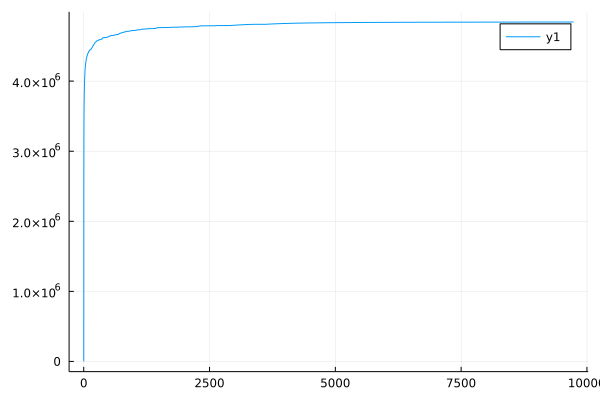

In [33]:
plot(1:length(offsets), offsets)

Analyze the average inner loop width for each level

In [84]:
avgwds = Float64[]
works = Int64[]
tworks = 0
cumworks = Int64[]
for level in levelSets
    wds = [ldliGp.colptr[i + 1] - ldliGp.colptr[i] for i in level]
    push!(avgwds, mean(wds))
    push!(works, sum(wds))
    tworks += sum(wds)
    push!(cumworks, tworks)
end

force to increase: cuting edges from node with low degree to high degree, subgraph become dense

force to decrease: cuting edges also reduces remaining nodes' degree (weight is merged)

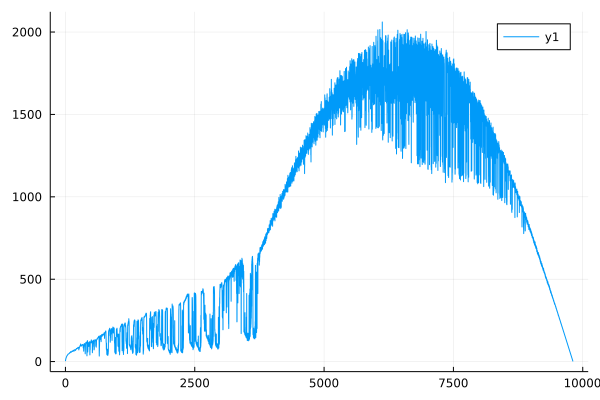

In [75]:
plot(avgwds)

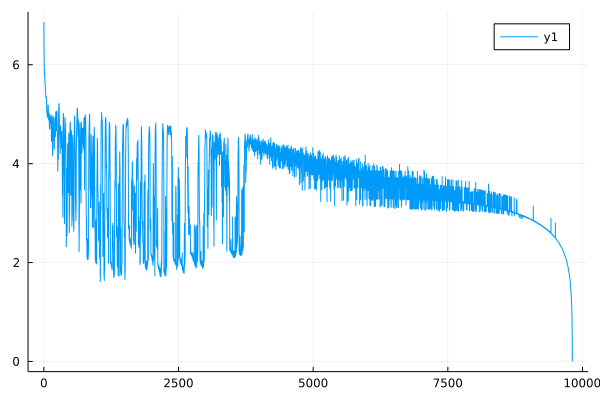

In [92]:
plot(log10.(works))

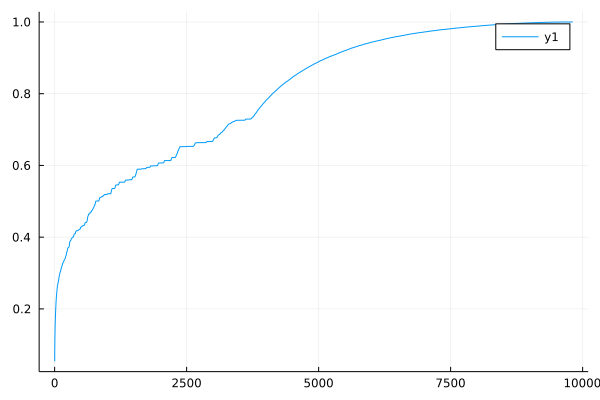

In [86]:
plot(cumworks ./ length(ldliGp.rowval))

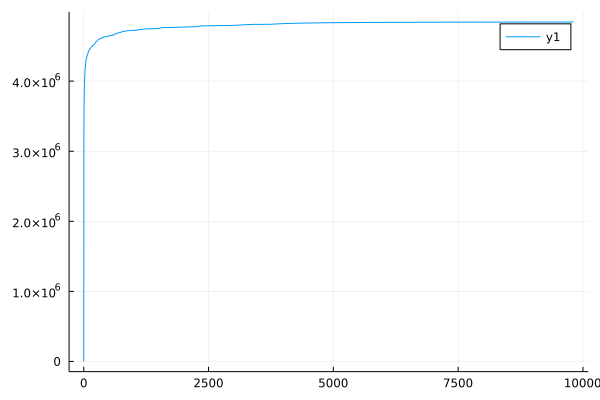

In [93]:
plot(parts)

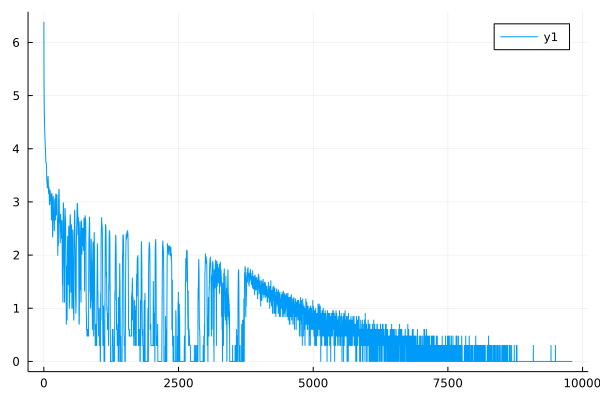

In [96]:
plot(log10.([parts[i + 1] - parts[i] for i in 1:(length(parts) - 1)]))

In [82]:
ldliGpr.colptr[4722624]

70897194

In [83]:
cut

935

In [88]:
ldliGpr.rowval

137128811-element Vector{Int64}:
 4305422
 4305396
 4305396
 4305352
 4305336
 4305313
 4305291
 4305237
 4305237
 4305232
 4305223
 4305223
 4305213
       ⋮
    9724
   36193
    9724
 4305461
    8485
   36193
 4305461
    8485
    9724
 4305461
    8485
 4305461

In [89]:
7/13

0.5384615384615384